In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from IPython.display import display
import scipy
from scipy import stats
import pystan

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Load and clean the data

In [3]:
DATE_FORMAT = r'%d/%m/%Y'

mauna_loa = pandas.read_csv(r'./weekly_in_situ_co2_mlo_data_only.csv')
first_day = datetime.strptime(mauna_loa['ds'][0], r'%d/%m/%Y')
mauna_loa['day'] = [(datetime.strptime(date_string, DATE_FORMAT) - first_day).days
                    for date_string in mauna_loa['ds']]

day_range = max(mauna_loa['day']) - min(mauna_loa['day'])
mauna_loa['norm_day'] = mauna_loa['day'] / day_range * 2

y_min = min(mauna_loa['y'])
y_range = max(mauna_loa['y']) - y_min
mauna_loa['norm_y'] = (mauna_loa['y'] - y_min)/ y_range

mauna_loa.head()

,ds,y,day,norm_day,norm_y
0,29/03/1958,316.19,0,0.000000,0.032427
1,05/04/1958,317.31,7,0.000643,0.043957
2,12/04/1958,317.69,14,0.001286,0.047869
3,19/04/1958,317.58,21,0.001929,0.046737
4,26/04/1958,316.48,28,0.002572,0.035413


In [4]:
min(mauna_loa['norm_y']), max(mauna_loa['norm_y']), min(mauna_loa['norm_day']), max(mauna_loa['norm_day'])

(0.0, 1.0, 0.0, 2.0)

In [5]:
2 * np.pi / (365.25 / day_range)

374.4967669741262

In [ ]:
mauna_loa.to_csv('./cleaned_mauna_loa_data.csv')

In [ ]:
mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8))

In [ ]:
from pandas.plotting import autocorrelation_plot, lag_plot

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(mauna_loa['norm_y'], ax)

In [ ]:
y_diffs = [y - x for x, y in zip(mauna_loa['norm_y'], mauna_loa['norm_y'][1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(y_diffs, ax)

In [ ]:
second_diffs = [y - x for x, y in zip(y_diffs, y_diffs[1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(second_diffs, ax)

In [ ]:
t_diffs = [y - x for x, y in zip(y_diffs, y_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t_diffs, ax)

In [ ]:
t2_diffs = [y - x for x, y in zip(t_diffs, t_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t2_diffs, ax)

In [ ]:
corr = np.correlate(t_diffs, t_diffs, 'same')
half_corr = corr[corr.shape[0] // 2:]
fig = plt.figure(figsize=(12, 8))
plt.plot(half_corr)

In [ ]:
np.argmax(half_corr[1:])

In [ ]:
import statsmodels.api as sm

dta = sm.datasets.co2.load_pandas().data
# deal with missing values. see issue
dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(dta.co2)

fig = plt.figure(figsize=(12, 8))
resplot = res.plot()

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.trend)

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.seasonal[1000:1200])

## This does not look promising. In the mean time, let's go for a different model

**TODO:**
* Compare different polynomial degrees
* Convert regression to feature vector
* Consider setting local slope as an MA rather than linear regression
* Importance sampling for model comparison?
* Triangular wave with steeper downwards slope?

In [6]:
# TRAIN_SIZE = 1040
# TEST_SIZE = 1040
# train = mauna_loa[:TRAIN_SIZE]
# test = mauna_loa[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]

TEST_SIZE = 0.25
N = len(mauna_loa)

train = mauna_loa[:int(-N * TEST_SIZE)]
test = mauna_loa[int(-N * TEST_SIZE):]
len(mauna_loa), len(train), len(test)

(3040, 2280, 760)

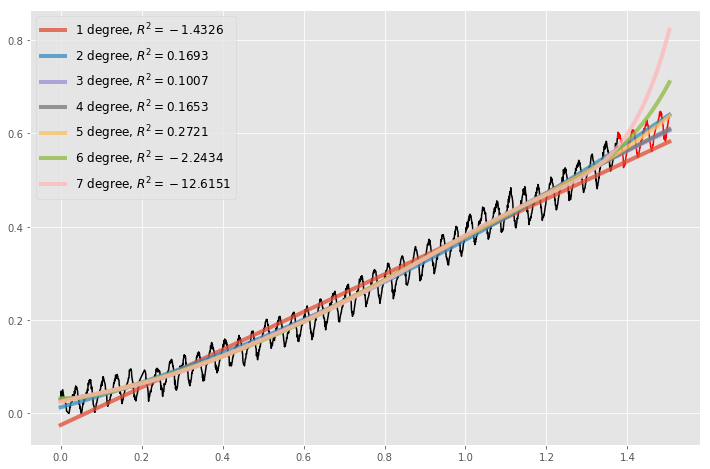

In [7]:
# adapted from http://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

from sklearn.linear_model import Ridge, LassoLarsIC, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.asarray(train['norm_day']).reshape(-1, 1)
y = np.asarray(train['norm_y'])

X_train = X[:-200]
y_train = y[:-200]
X_test = X[-200:]
y_test = y[-200:]

fig = plt.figure(figsize=(12, 8))
plt.plot(X_train, y_train, color='black')
plt.plot(X_test, y_test, color='red')

for count, degree in enumerate(range(1, 8)):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()) # LassoLarsIC(criterion='bic'))
    model.fit(X_train, y_train)
#     ic = np.sum(model.steps[1][1].criterion_)
    y_plot = model.predict(X)
    plt.plot(X, y_plot, lw=4, alpha=0.75,
             label='{d} degree, $R^2 = {r2:.4f}$'.format(d=degree, r2=model.score(X_test, y_test)))
#             label='{d} degree, $R^2 = {r2:.4f}$, ic = {ic:.3e}'.format(
#                 d=degree, r2=model.score(X_test, y_test), ic=ic))

plt.legend(loc=2, fontsize=12)

In [8]:
sinuosdial_model = """
functions {
    vector poly_features(real t, int poly_deg) {
        vector[poly_deg] features;
        for (i in 1:poly_deg){
            features[i] = t ^ (i - 1);
        }
        return features;
    }

    real poly_trend(real t_i, vector b, int poly_deg) {
        return dot_product(b, poly_features(t_i, poly_deg));
    }
    
    real cos_seasonality(real t_i, real alpha, real unbound_omega, real phi) {
        return alpha * cos(unbound_omega * t_i + phi);
    }
    
    real asym_trinagle_seasonality(real t_i, real alpha, real unbound_omega, real phi, real min_point) {
        real x = fmod(t_i * unbound_omega + phi, 2 * pi());
        if (x < min_point) {
            return alpha * (1 - (2 * x / min_point));
        }
        
        return alpha * (2 * x - min_point - 2 * pi()) / (2 * pi() - min_point);
    }

    real poly_cos_model_mean(real t_i, vector b, int poly_deg, real alpha, real unbound_omega, real phi) {
        return poly_trend(t_i, b, poly_deg) + cos_seasonality(t_i, alpha, unbound_omega, phi);
    }
    
    real poly_tri_model_mean(real t_i, vector b, int poly_deg, real alpha, real unbound_omega, real phi, real min_point) {
        return poly_trend(t_i, b, poly_deg) + asym_trinagle_seasonality(t_i, alpha, unbound_omega, phi, min_point);
    }
}


data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days
    vector[N_future] t_future;      // the days
    real unbound_omega_zero;  // the initial omega
    real unbound_alpha_zero;  // the initial alpha
    int<lower=1> poly_degree;
}

parameters {
    vector[poly_degree] b;

    real unbound_omega; // the frequency parameter, in its unbound form
    real phi_x; // x and y coordinate to atan2 the phase shift from
    real phi_y;
    real unbound_alpha; // the amplitude frequency in its unbound form
    real unbound_sigma_y; // overall prediction residual error
    
    real min_point_x; // x and y coordinate to atan2 the min point from
    real min_point_y;
}

transformed parameters {
    real phi;
    real<lower=0> alpha;
    real<lower=0> sigma_y;
    real min_point;
    
    phi = atan2(phi_x, phi_y);
    // phi = exp(phi_x);
    alpha = exp(unbound_alpha);
    sigma_y = exp(unbound_sigma_y);
    
    
    min_point = atan2(min_point_x, min_point_y) + pi();
}

model {
    // Priors
    b[1] ~ normal(0, 0.2);
    for (i in 2:poly_degree) {
        b[i] ~ normal(0, 1);
    }
    
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    // unbound_omega ~ normal(unbound_omega_zero, unbound_omega_zero / 6);
    unbound_alpha ~ normal(unbound_alpha_zero, 1);
    unbound_sigma_y ~ normal(-1, 1);
    
    for (i in 1:N) {
        y[i] ~ normal(poly_cos_model_mean(t[i], b, poly_degree, alpha, 187.2484, phi), sigma_y); // unbound_omega
    }
}

generated quantities {
    real y_simulated_train[N];
    real y_future[N_future];
    
    for(i in 1:N) {
        y_simulated_train[i] = normal_rng(poly_cos_model_mean(t[i], b, poly_degree, alpha, unbound_omega, phi), sigma_y);
    }
    
    for(i in 1:N_future) {
        y_future[i] = normal_rng(poly_cos_model_mean(t_future[i], b, poly_degree, alpha, unbound_omega, phi), sigma_y);
    }
}
"""

sm = pystan.StanModel(model_code=sinuosdial_model, model_name='sinusodial_model', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sinusodial_model_de4bf467855ca7cfd5795b76a0e28cc8 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.27.3


Compiling /tmp/tmpzxarcpae/stanfit4sinusodial_model_de4bf467855ca7cfd5795b76a0e28cc8_3057956938832390342.pyx because it changed.
[1/1] Cythonizing /tmp/tmpzxarcpae/stanfit4sinusodial_model_de4bf467855ca7cfd5795b76a0e28cc8_3057956938832390342.pyx
building 'stanfit4sinusodial_model_de4bf467855ca7cfd5795b76a0e28cc8_3057956938832390342' extension
creating /tmp/tmpzxarcpae/tmp
creating /tmp/tmpzxarcpae/tmp/tmpzxarcpae
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpzxarcpae -I/opt/anaconda3/lib/python3.6/site-packages/pystan -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/anaconda3/lib/python3.6/site-packages/pystan

In [9]:
unbound_omega_zero = 2 * np.pi / (365.25 / day_range * 2)
print(unbound_omega_zero)
unbound_alpha_zero = -3
polynomial_terms = 4

sinusodial_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
    't_future': test['norm_day'],
    'unbound_omega_zero': unbound_omega_zero,
    'unbound_alpha_zero': unbound_alpha_zero,
    'poly_degree': polynomial_terms
}

fit = sm.sampling(data=sinusodial_data, iter=1000, chains=4, n_jobs=8, verbose=True,
                  init=lambda: {'b': [0] * polynomial_terms, 
                                'unbound_omega': unbound_omega_zero, 'unbound_phi': 0, 
                                'unbound_alpha': unbound_alpha_zero, 'unbound_sigma_y': -1, 
                                'sigma_y': np.exp(-1),
                               }
                  )

samples = fit.extract()
fit

187.2483834870631


Inference for Stan model: sinusodial_model_de4bf467855ca7cfd5795b76a0e28cc8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]                      0.02  1.8e-5 7.4e-4   0.02   0.02   0.02   0.03   0.03   1656    nan
b[1]                      0.15  1.1e-4 4.1e-3   0.14   0.15   0.15   0.15   0.16   1497    1.0
b[2]                      0.28  1.6e-4 6.3e-3   0.27   0.27   0.28   0.28   0.29   1495    1.0
b[3]                     -0.08  7.1e-5 2.8e-3  -0.08  -0.08  -0.08  -0.07  -0.07   1524    1.0
unbound_omega            2.4e4   1.6e4  2.7e4  -9978 2702.5  2.0e4  3.2e4  9.6e4      3   3.97
phi_x                    -0.51    0.01   0.26  -1.09  -0.67  -0.48  -0.32  -0.13    484    1.0
phi_y                     1.12    0.03   0.56   0.28    0.7   1.05   1.46   2.36    484    1.0
unbound_alpha            -3.55  2.3e-4 9.8e-3  

0.005714796136362365


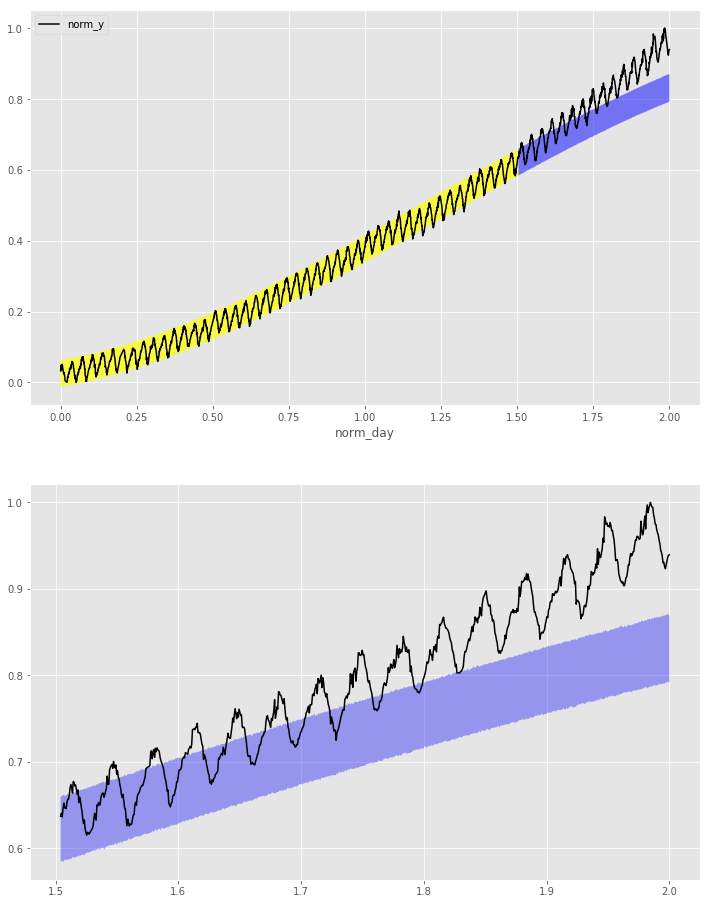

In [10]:
def plot_samples(samples):
    fig = plt.figure(figsize=(12, 16))
    gs = gridspec.GridSpec(2, 1)

    y_future_means = np.mean(samples['y_future'], axis=0)
    y_future_stds = np.std(samples['y_future'], axis=0)
    
    y_future_lower = np.percentile(samples['y_future'], 2.5, axis=0)
    y_future_upper = np.percentile(samples['y_future'], 97.5, axis=0)
    
    y_simulated_lower = np.percentile(samples['y_simulated_train'], 2.5, axis=0)
    y_simulated_upper = np.percentile(samples['y_simulated_train'], 97.5, axis=0)

    top_ax = plt.subplot(gs[0, 0])
    mauna_loa.plot(x='norm_day', y='norm_y', color='black', ax=top_ax)
    top_ax.fill_between(train['norm_day'], y_simulated_lower, y_simulated_upper, alpha=0.7, facecolor='yellow')
    top_ax.fill_between(test['norm_day'], y_future_lower, y_future_upper, alpha=0.5, facecolor='blue')
#     left_ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
#                     y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.35, facecolor='blue')

    bottom_ax = plt.subplot(gs[1, 0])
    bottom_ax.plot(test['norm_day'], test['norm_y'], color='black')
    bottom_ax.fill_between(test['norm_day'], y_future_lower, y_future_upper, alpha=0.35, facecolor='blue')
    
    mse = np.mean((test['norm_y'] - y_future_means) ** 2)
    print(mse)
    
    plt.show()


plot_samples(samples)

In [ ]:

y_test = test['norm_y'].as_matrix()
y_mean = np.mean(samples['y_future'], axis=0)
np.mean((y_test - y_mean) ** 2)

In [ ]:
y_test.shape

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(range(samples['b'].shape[0]), [b[1] for b in samples['b']])

In [ ]:
samples['b'].shape

In [ ]:
import pickle

In [ ]:
with open('model_samples.pickle', 'wb') as out_file:
    pickle.dump(samples, out_file)